# Perfect sampling of 2D Ising Model

## Hamiltonian
\begin{align}
H = -\sum_{<ij>}J_{ij}S_{i} S_{j} - \sum_{i} h_{i}S_{i},
\end{align}
where we assume $J_{ij} = J$ and $h_{i} = h$.

----

### Perfect Sampling of 2D ISING model

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
import time

In [4]:
class ISING_2D_psampling:
    
    def __init__(self, j=1, beta=1, h=1, dims=(10, 10)):
        """
        Args:
            nc: (int) size of the cluster.
        """
        self.j = j
        self.beta = beta
        self.h = h
        self.dims = dims
        self.grids = (-1) ** np.reshape(np.random.binomial(1, 1/2, dims[0]*dims[1]), dims)
        #self.grids = (-1) ** np.zeros(dims)
        #self.grids = np.ones(dims)
        self.dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        
    def neibor_get(self, id_grid):
        height, width = self.dims
        height_index, width_index = id_grid
        l_neibor = (height_index, (width_index - 1) % width)
        r_neibor = (height_index, (width_index + 1) % width)
        u_neibor = ((height_index - 1) % height, width_index)
        d_neibor = ((height_index + 1) % height, width_index)          
        ur_neibor = ((height_index - 1) % height, (width_index + 1) % width)
        dl_neibor = ((height_index + 1) % height, (width_index - 1) % width)
        
        return {'l': l_neibor, 
                'r': r_neibor, 
                'u': u_neibor, 
                'd': d_neibor, 
                'ur': ur_neibor, 
                'dl': dl_neibor}
    
    def message_on_node(self, id_node, id_neibors):
        def energy_get(spin, id_neibors):
            energy = 0
            for id_neibor in id_neibors:
                energy += -self.j * spin * self.grids[id_neibor[0]][id_neibor[1]]
            energy += -self.h * spin
            return energy
        spin_up, spin_down = 1, -1
        energy_up = energy_get(spin_up, id_neibors)
        energy_down = -energy_up
        #message = np.array([1, np.exp(self.beta * (energy_up - energy_down))])
        message = np.array([np.exp(-self.beta * energy_up), np.exp(-self.beta * energy_down)])
        energy_list = [energy_up, energy_down]
        #message_norm = message / np.sum(message)
        #return message_norm
        return message
    
    def message_on_edge(self):
        """
        Args:
            edge: (tuple) (node_start, node_end)
            
        Returns:
            message: (np.array) 2x2 matrix
        """
        #row_start_up = [1, np.exp(-2*self.beta*self.j)]
        #row_start_down = [np.exp(-2*self.beta*self.j), 1]
        row_start_up = [np.exp(self.beta*self.j), np.exp(-1*self.beta*self.j)]
        row_start_down = [np.exp(-1*self.beta*self.j), np.exp(self.beta*self.j)]
        message = np.array([row_start_up, row_start_down])
        return message
    
    def loop_sampling(self, id_height):
        id_end = np.random.randint(self.dims[1])
        id_start = (id_end + 1) % self.dims[1]
        path_to_left = [id_start, id_end] 
        path_to_right = [(id_start + i) % self.dims[1] for i in range(self.dims[1])]
        assert path_to_right[-1] == id_end, "Path to right is not right!"
        ### get the message on the edge which is shared by all the other edge
        message_edge = self.message_on_edge()
        message_on_node = []
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        for id_width in range(self.dims[1]):  
            neibors_node = self.neibor_get((id_height, id_width))
            keys_neibors = ('u', 'ur', 'dl', 'd')
            neibors_node = dict_filter(neibors_node, keys_neibors)
            message_node = self.message_on_node((id_height, id_width), neibors_node)
            message_on_node.append(message_node)
        z_right = np.sqrt(message_on_node[id_start])
        z_left = np.sqrt(message_on_node[id_start])
        id_start_right = id_start
        while id_start_right != id_end:
            id_start_right = (id_start_right + 1) % self.dims[1]
            z_right = np.matmul(z_right, message_edge)
            if id_start_right == id_end:
                z_right *= np.sqrt(message_on_node[id_start_right])
            else:
                z_right *= message_on_node[id_start_right]
        id_start_left = id_start
        while id_start_left != id_end:
            id_start_left = (id_start_left - 1) % self.dims[1]
            z_left = np.matmul(z_left, message_edge)
            if id_start_left == id_end:
                z_left *= np.sqrt(message_on_node[id_start_left])
            else:
                z_left *= message_on_node[id_start_left]      
        z = z_left * z_right
        z_norm = z / np.sum(z)
        if np.random.uniform(0, 1) < z_norm[0]:
            spin_start = 1
        else:
            spin_start = -1
        self.grids[id_height][id_end] = spin_start
        return id_end
    
    def _loop_sampling_test(self, id_height, id_start):
        id_end = (id_start - 1) % self.dims[1]
        path_to_left = [id_start, id_end] 
        path_to_right = [(id_start + i) % self.dims[1] for i in range(self.dims[1])]
        assert path_to_right[-1] == id_end, "Path to right is not right!"
        ### get the message on the edge which is shared by all the other edge
        message_edge = self.message_on_edge()
        message_on_node = []
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        energy_on_node = []
        for id_width in range(self.dims[1]):  
            neibors_node = self.neibor_get((id_height, id_width))
            keys_neibors = ('u', 'ur', 'dl', 'd')
            neibors_node = dict_filter(neibors_node, keys_neibors)
            message_node, energy_list = self.message_on_node((id_height, id_width), neibors_node)
            message_on_node.append(message_node)
            energy_on_node.append(energy_list)
        #print(message_on_node)
        z_right = np.sqrt(message_on_node[id_start])
        z_left = np.sqrt(message_on_node[id_start])
        id_start_right = id_start
        while id_start_right != id_end:
            id_start_right = (id_start_right + 1) % self.dims[1]
            z_right = np.matmul(z_right, message_edge)
            #print('z_right', id_start_right, z_right)
            if id_start_right == id_end:
                z_right *= np.sqrt(message_on_node[id_start_right])
            else:
                z_right *= message_on_node[id_start_right]
        id_start_left = id_start
        while id_start_left != id_end:
            id_start_left = (id_start_left - 1) % self.dims[1]
            z_left = np.matmul(z_left, message_edge)
            #print('z_left', id_start_left, z_left)
            if id_start_left == id_end:
                z_left *= np.sqrt(message_on_node[id_start_left])
            else:
                z_left *= message_on_node[id_start_left]      
        z_vec = z_left * z_right
        z = np.sum(z_vec)
        z_norm = z_vec / z
        
        return z_norm, z, energy_on_node
    
    def _exact_loop_sampling(self, id_height, id_start):
        def energy_compute(id_width, grids):
            energy_site = 0
            id_spin = grids[id_height][id_width]
            id_site = (id_height, id_width)
            id_neibors_orig = self.neibor_get(id_site)
            keys_neibors = ('u', 'd', 'ur', 'dl')
            id_neibors = self.dict_filter(id_neibors_orig, keys_neibors)
            for neibor in id_neibors:
                energy_site += (-self.j * grids[neibor[0]][neibor[1]] * id_spin)
            keys_neibors = ('l', 'r')
            id_neibors = self.dict_filter(id_neibors_orig, keys_neibors)
            for neibor in id_neibors:
                energy_site += -1/2 * self.j * grids[neibor[0]][neibor[1]] * id_spin
            energy_site += -self.h * id_spin
            return energy_site
        
        def z_site_compute(grids):
            energy_full = 0
            for id_width in range(self.dims[1]):
                energy_full += energy_compute(id_width, grids)
            z_part = np.exp(-self.beta * energy_full)
            return z_part, energy_full
        
        def z_part_compute(id_start, spin_start, grids):
            num_site = 2 ** (self.dims[1] - 1)
            z_part_start = 0
            energy_list = []
            for i in range(num_site):
                site_i = list('0' * self.dims[1] + bin(i)[2:])[1-self.dims[1]:]
                site_i.insert(id_start, spin_start)
                site_i = np.array(site_i, dtype=np.int32)
                site_i = (-1) ** site_i
                grids[id_height] = site_i
                #print(grids)
                z_i, energy_i = z_site_compute(grids)
                z_part_start += z_i
                energy_list.append(energy_i)
            return z_part_start, energy_list
        
        spin_u, spin_d = '0', '1'
        grids = self.grids.copy()
        z_part_u, energy_list_u = z_part_compute(id_start, spin_u, grids)
        z_part_d, energy_list_d = z_part_compute(id_start, spin_d, grids)
        z_start = np.array([z_part_u, z_part_d])
        z = np.sum(z_start)
        return z_start / z, z, energy_list_u, energy_list_d
    
    def chain_sampling(self, id_height, id_start):
        stack = []
        id_end = (id_start - 1) % self.dims[1]
        id_start = (id_start + 1) % self.dims[1]
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        if self.dims[1] > 2:
            id_neibors = self.neibor_get((id_height, id_start))
            keys_neibors = ('l', 'u', 'ur', 'd', 'dl')
            id_neibors = dict_filter(id_neibors, keys_neibors)
        else:
            id_neibors = self.neibor_get((id_height, id_start))
        message_edge = self.message_on_edge()
        z_start = self.message_on_node((id_height, id_start), id_neibors)
        stack.append(z_start)
        while id_start != id_end:
            id_start = (id_start + 1) % self.dims[1]
            z_start = np.matmul(z_start, message_edge)
            if id_start == id_end:
                id_neibors = self.neibor_get((id_height, id_start))
                keys_neibors = ('r', 'u', 'd', 'ur', 'dl')
                id_neibors = dict_filter(id_neibors, keys_neibors)
            else:
                id_neibors = self.neibor_get((id_height, id_start))
                keys_neibors = ('u', 'ur', 'd', 'dl')
                id_neibors = dict_filter(id_neibors, keys_neibors)
            node_message = self.message_on_node((id_height, id_start), id_neibors)
            z_start = z_start * node_message
            stack.append(z_start)
        z_start = stack.pop()
        z_start_norm = z_start / np.sum(z_start)
        if np.random.uniform(0, 1) < z_start_norm[0]:
            spin_start = 1
        else:
            spin_start = -1
        self.grids[id_height][id_start] = spin_start
        
        return stack, id_start
    
    def backtrack_sampling(self, id_height, id_start, stack):
        spins_list = []
        message_edge = self.message_on_edge()
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        while len(stack) != 0:
            id_start = (id_start - 1) % self.dims[1]   
            id_neibors = self.neibor_get((id_height, id_start))
            #if len(stack) > 1:
            #keys_neibors = ('l', 'u', 'ur', 'd', 'dl')
            keys_neibors = ('r')
            id_neibors = dict_filter(id_neibors, keys_neibors)
            message_node = self.message_on_node((id_height, id_start), id_neibors)
            z_start = message_node * stack.pop()
            z_norm = z_start / np.sum(z_start)
            if np.random.uniform(0, 1) < z_norm[0]:
                spin_start = 1
            else:
                spin_start = -1
            self.grids[id_height][id_start] = spin_start
            spins_list.append(spin_start)
    
    def one_row_sampling(self, id_height):
        id_start = self.loop_sampling(id_height)
        stack, id_start = self.chain_sampling(id_height, id_start)
        self.backtrack_sampling(id_height, id_start, stack)
        
    def chain_evolution(self):
        for i in range(self.dims[0]):
            self.one_row_sampling(i) 
        #self.grids = np.transpose(self.grids)
        #for i in range(self.dims[1]):
        #    self.one_row_sampling(i)
        #self.grids = np.transpose(self.grids)
        
    def tree_create(self):
        def neibor_search(id_grid, tree_list):
            height, width = id_grid
            neibors = []
            num_shared = 0
            if height < self.dims[0] - 1:
                if (height + 1, width) not in tree_list:
                    neibors.append((height + 1, width))
                else:
                    num_shared += 1
            if height > 0:
                if (height - 1, width) not in tree_list:
                    neibors.append((height - 1, width))
                else:
                    num_shared += 1
            if width < self.dims[1] - 1:
                if (height, width + 1) not in tree_list:
                    neibors.append((height, width + 1))
                else:
                    num_shared += 1
            if width > 0:
                if (height, width - 1) not in tree_list:
                    neibors.append((height, width - 1))
                else:
                    num_shared += 1
                    
            return neibors, num_shared
        
        tree_list = []
        stack = []
        height, width = self.dims
        height_rand = np.random.randint(0, height)
        width_rand = np.random.randint(0, width)
        id_start = (height_rand, width_rand)
        stack.append(id_start)
        while len(tree_list) < self.nc:
            node_leaf = stack.pop()
            if node_leaf in tree_list:
                tree_list.pop()
                continue
            neibors_leaf, num_shared = neibor_search(node_leaf, tree_list)
            if len(neibors_leaf) >= 1 and num_shared < 2:
                tree_list.append(node_leaf)
                stack.append(node_leaf)
                stack.extend(neibors_leaf)
            else:
                if node_leaf == tree_list[-1]:
                    tree_list.pop()
        return tree_list
    
    def tree_viz(self):
        zero_one_row = 'o' * self.dims[1] + '\n'
        zeros_grids = zero_one_row * self.dims[0]
        for node in self.tree_list:
            node_pos = node[0] * (self.dims[1] + 1) + node[1]
            zeros_grids = zeros_grids[:node_pos] + 'x' + zeros_grids[node_pos+1:]
        print(zeros_grids)
        
    def spin_viz(self, figsize=(10, 10), save=False, folder_name=None):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.dims[0]), np.arange(0, self.dims[1]))
        u = np.cos(self.grids*np.pi/2)
        v = np.sin(self.grids*np.pi/2)
        q = plt.quiver(x, y, u, v)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.dims), fontsize=20)
        if save and step is not None:
            plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
            plt.close(fig)

    def energy_compute_grids(self):
        energy_total = 0
        for i in range(self.dims[0]):
            for j in range(self.dims[1]):
                id_neibors_dict = self.neibor_get((i, j))
                id_neibors = id_neibors_dict.values()
                energy_ij = 0
                for ij in id_neibors:
                    energy_ij = -1/2 * self.j * self.grids[ij[0]][ij[1]] * self.grids[i][j]
                    energy_total += energy_ij
                ### compute the energy of external field
                energy_total += -self.h * self.grids[i][j]
        energy_per_spin = energy_total / (self.dims[0] * self.dims[1])
        return energy_per_spin
    
    def magnet_grids(self):
        magnet_x, magnet_y = 0, 0
        for i in range(self.length):
            magnet_x += np.sin(self.grids[i])
            magnet_y += np.cos(self.grids[i])
        return magnet_x, magnet_y

### External Field h = 0

In [192]:
ising_2d = ISING_2D_psampling(beta=100, j=1, h=0, dims=(5, 5))

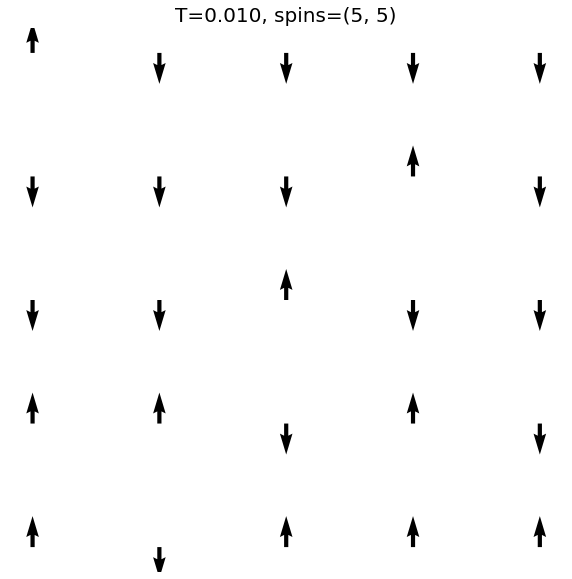

In [193]:
ising_2d.spin_viz()

In [194]:
ising_2d.chain_evolution()

/tmp/ipykernel_144/1818059112.py:41: RuntimeWarning: overflow encountered in exp
  message = np.array([1, np.exp(self.beta * (energy_up - energy_down))])
/tmp/ipykernel_144/1818059112.py:42: RuntimeWarning: invalid value encountered in true_divide
  message_norm = message / np.sum(message)


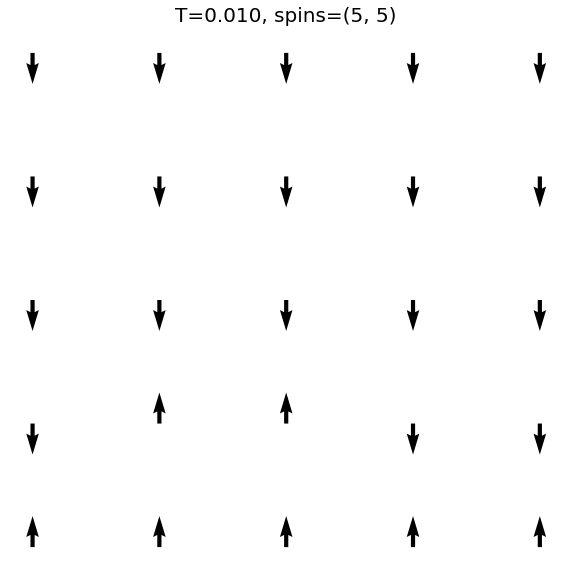

In [195]:
ising_2d.spin_viz()

In [196]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -1.240.


------

In [197]:
ising_2d = ISING_2D_psampling(beta=1, j=1, h=0, dims=(5, 5))

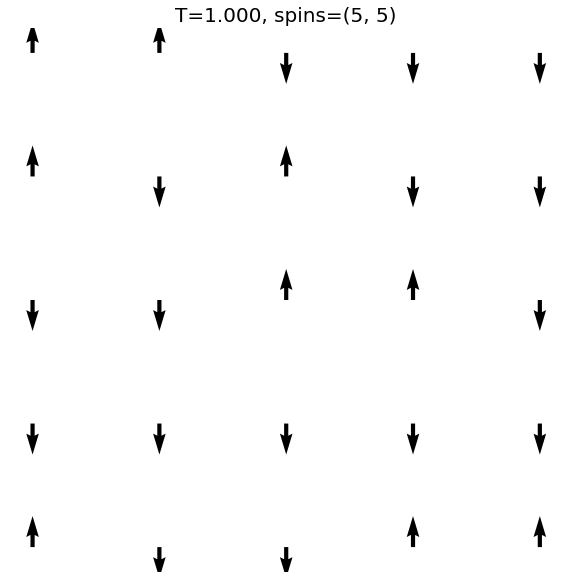

In [198]:
ising_2d.spin_viz()

In [199]:
ising_2d.chain_evolution()

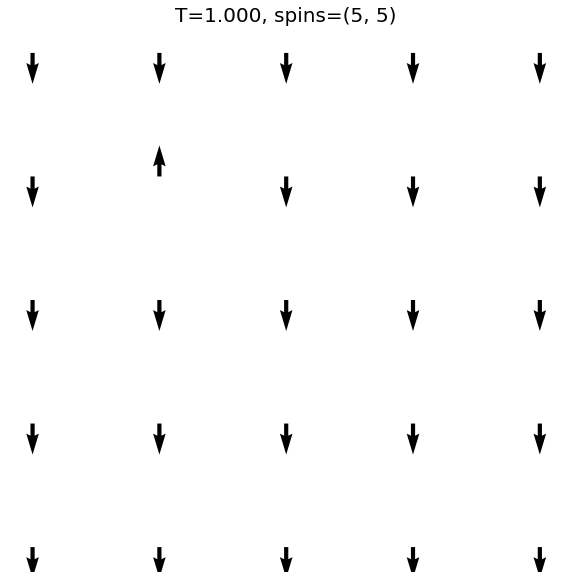

In [200]:
ising_2d.spin_viz()

In [201]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -2.520.


------

### External Field  h = 1

In [202]:
ising_2d = ISING_2D_psampling(beta=1, j=1, h=1, dims=(5, 5))

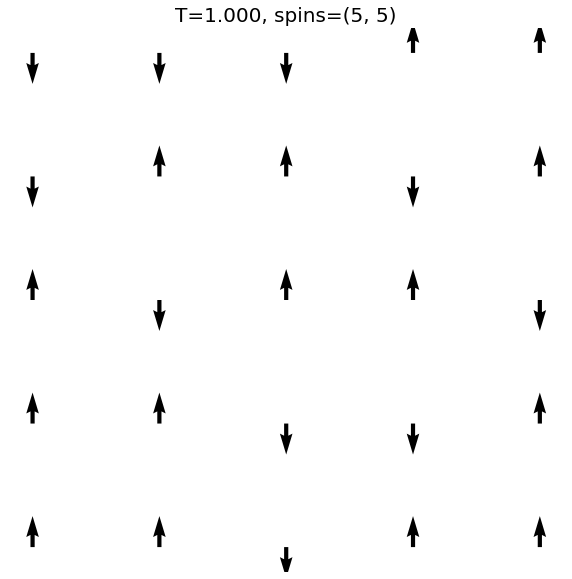

In [203]:
ising_2d.spin_viz()

In [204]:
for _ in trange(1000):
    ising_2d.chain_evolution()

  0%|          | 0/1000 [00:00<?, ?it/s]

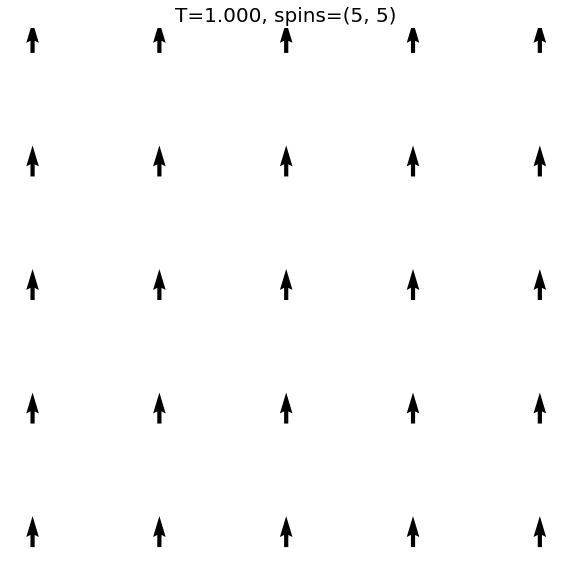

In [205]:
ising_2d.spin_viz()

In [206]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -4.000.


---
### High Temperature 

In [207]:
ising_2d = ISING_2D_psampling(beta=0.1, j=1, h=0, dims=(5, 5))

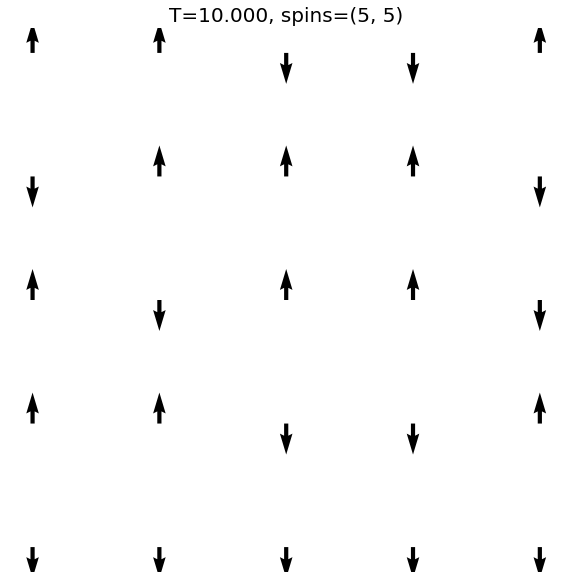

In [208]:
ising_2d.spin_viz()

In [209]:
for _ in trange(10000):
    ising_2d.chain_evolution()

  0%|          | 0/10000 [00:00<?, ?it/s]

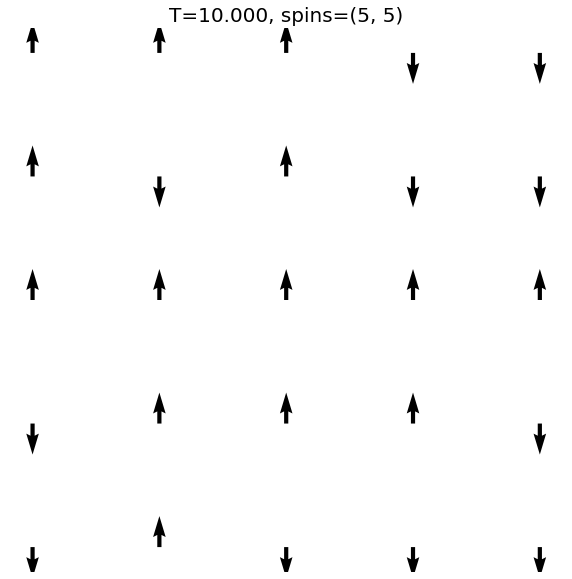

In [210]:
ising_2d.spin_viz()

In [211]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -0.440.


In [212]:
energy_list = []
for _ in trange(10000):
    energy_list.append(ising_2d.energy_compute_grids())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [213]:
np.std(energy_list)

1.6653345369377348e-16

-----------
### J > 0

In [531]:
beta_list = [0.05 * i for i in range(1, 11)]
temp_list = [1 / beta for beta in beta_list]
dims = (5, 5)

In [536]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(10):
    beta = beta_list[i]
    ising_2d = ISING_2D_psampling(beta=beta, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(10000):
        ising_2d.chain_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(10000):
        ising_2d.chain_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [537]:
mean_sampling_list

[-0.16776000000000002,
 -0.36776000000000003,
 -0.653024,
 -1.101888,
 -1.8058559999999997,
 -2.3997279999999996,
 -2.721776,
 -2.867424,
 -2.9326239999999997,
 -2.96496]

In [538]:
std_sampling_list

[0.383693135721764,
 0.43906075023850627,
 0.5168315542069776,
 0.6969958073446354,
 0.7792157770887342,
 0.6215551512263413,
 0.413151069009872,
 0.271313111043311,
 0.18710936540964485,
 0.13258189318304367]

In [539]:
energy_metropolis_list = [-0.164896,
                          -0.3740704,
                          -0.6458208,
                          -1.1592592,
                          -1.8570512,
                          -2.450304,
                          -2.7503168000000007,
                          -2.8719392,
                          -2.9364928000000003,
                          -2.9658368000000004]

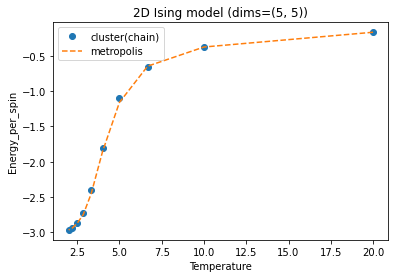

In [541]:
plt.plot(temp_list, mean_sampling_list, 'o', label='cluster(chain)')
plt.plot(temp_list, energy_metropolis_list, '--', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5))')
plt.legend()

### J < 0

In [5]:
beta_list = [0.02 * i for i in range(1, 21)]
temp_list = [1 / beta for beta in beta_list]
dims, j = (5, 5), -1

In [6]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(20):
    beta = beta_list[i]
    ising_2d = ISING_2D_psampling(beta=beta, j=j, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(10000):
        ising_2d.chain_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(10000):
        ising_2d.chain_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [7]:
mean_sampling_list

[-0.05904000000000001,
 -0.11104000000000001,
 -0.162912,
 -0.20542400000000002,
 -0.24467200000000003,
 -0.289296,
 -0.32657600000000003,
 -0.36264,
 -0.39779200000000003,
 -0.42616000000000004,
 -0.458032,
 -0.482608,
 -0.512304,
 -0.5334079999999999,
 -0.561248,
 -0.580368,
 -0.6036319999999998,
 -0.6274879999999999,
 -0.640048,
 -0.6564479999999999]

In [8]:
std_sampling_list

[0.32786490876579033,
 0.3183181402308074,
 0.3063433372149621,
 0.3010956330204741,
 0.2885349414126476,
 0.2772677846126376,
 0.26698725854242555,
 0.2625866531261633,
 0.24980553383782356,
 0.2453649820165869,
 0.23679452480156718,
 0.23303407119131742,
 0.2256956614204181,
 0.21895914124785928,
 0.21226031776099835,
 0.2060551978863916,
 0.20415427640879827,
 0.1937840288981525,
 0.18945985774300583,
 0.18577454964553136]

In [9]:
energy_metropolis_list = [-0.0593264,
                          -0.1117728,
                          -0.15559360000000003,
                          -0.2061952,
                          -0.24400640000000004,
                          -0.2867968,
                          -0.32193440000000006,
                          -0.3552624,
                          -0.39665120000000004,
                          -0.42617279999999996,
                          -0.4607104,
                          -0.4826992,
                          -0.49970399999999987,
                          -0.5395984,
                          -0.5640528,
                          -0.5806271999999999,
                          -0.6022255999999999,
                          -0.6232991999999998,
                          -0.6436031999999999,
                          -0.6594736]

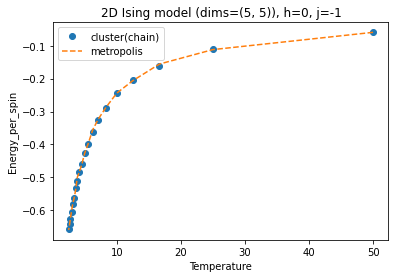

In [11]:
plt.plot(temp_list, mean_sampling_list, 'o', label='cluster(chain)')
plt.plot(temp_list, energy_metropolis_list, '--', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5)), h=0, j=-1')
plt.legend()